# Australian tourism

## Import data

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
tourism_data = pd.read_csv('TourismData_v3.csv')

In [2]:
type_float64 = True

if type_float64:
  torch.set_default_dtype(torch.float64)
  np_dtype = np.float64
else:
  torch.set_default_dtype(torch.float32)
  np_dtype = np.float32

In [3]:
print(torch.cuda.is_available())

True


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Package

### S matrix

In [5]:
def create_sum_matrix(identifiers, lambdas, device):
    states = sorted(set([id[:1] for id in identifiers]))
    zones = sorted(set([id[:2] for id in identifiers]))
    regions = sorted(set([id[:3] for id in identifiers]))

    n_states = len(states)
    n_zones = len(zones)
    n_regions = len(regions)
    n_categories = len(identifiers)
    n_tot = 1 + n_states + n_zones + n_regions +n_categories

    lambda_tot = lambdas["lambda_tot"]
    lambda_states = lambdas["lambda_states"]
    lambda_zones = lambdas["lambda_zones"]
    lambda_regions = lambdas["lambda_regions"]
    lambda_categories = lambdas["lambda_categories"]

    lambda_mat = torch.eye(n_tot, device = device)

    S_mat = torch.zeros(n_tot, n_categories, device = device)

    #The first row of the S matrix is always filled with 1
    S_mat[0] = torch.ones(n_categories, device = device)
    lambda_mat[0,0] = lambda_tot
    counter = 1

    #Then, we fill the next rows with the state level
    for state in states:
        for i in range(n_categories):
            if identifiers[i][:1] == state:
                S_mat[counter, i] = 1
        lambda_mat[counter, counter] = lambda_states
        counter+=1

    #Then, we fill the next rows with the zone level
    for zone in zones:
        for i in range(n_categories):
            if identifiers[i][:2] == zone:
                S_mat[counter, i] = 1
        lambda_mat[counter, counter] = lambda_zones
        counter+=1

    #Then, we fill the next rows with the region level
    for region in regions:
        for i in range(n_categories):
            if identifiers[i][:3] == region:
                S_mat[counter, i] = 1
        lambda_mat[counter, counter] = lambda_regions
        counter+=1

    #Then, we fill the next rows with the category level
    for i in range(n_categories):
        S_mat[counter, i] = 1
        lambda_mat[counter, counter] = lambda_categories
        counter+=1
    return S_mat, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories




### Linear regression

In [6]:
def linear_weights(h_learn, start, tourism_data):
  lambdas = {
    "lambda_tot": 0,
    "lambda_states": 0,
    "lambda_zones": 0,
    "lambda_regions": 0,
    "lambda_categories":1}

  identifiers = tourism_data.keys()[2:]
  s_matrix_unscaled, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories = create_sum_matrix(identifiers, lambdas, device)
  y_train = torch.tensor(tourism_data.iloc[:start, 2:].values, device=device)

  thetas = []

  for i in range(n_tot):
    combination = s_matrix_unscaled[i]
    y_train_i = y_train@combination

    lagged_columns = []
    for lag in range(1,h_learn+1):
        lagged_col = torch.roll(y_train_i, shifts=lag)
        lagged_columns.append(lagged_col)

    x_train_i = torch.stack(lagged_columns, dim=1)[h_learn:start]
    y_train_i = y_train_i[h_learn:start]

    thetas.append(torch.linalg.solve(x_train_i.T@x_train_i, (x_train_i.T)@y_train_i))
  return thetas

def linear_regression(h_learn, start, end, tourism_data, thetas):
  lambdas = {
    "lambda_tot": 0,
    "lambda_states": 0,
    "lambda_zones": 0,
    "lambda_regions": 0,
    "lambda_categories":1}

  identifiers = tourism_data.keys()[2:]
  s_matrix_unscaled, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories = create_sum_matrix(identifiers, lambdas, device)
  y_test = torch.tensor(tourism_data.iloc[start-h_learn:end, 2:].values, device=device)

  tourism_tensor = torch.tensor(tourism_data.iloc[:, 2:].values, device=device)
  errors = []
  
  n_test = y_test.shape[0]
  se_table=pd.DataFrame()
  for i in range(n_tot):
    combination = s_matrix_unscaled[i]
    y_test_i = y_test@combination

    lagged_columns = []
    for lag in range(1,h_learn+1):
        lagged_col = torch.roll(y_test_i, shifts=lag)
        lagged_columns.append(lagged_col)

    x_test_i = torch.stack(lagged_columns, dim=1)[h_learn:]
    y_test_i = y_test_i[h_learn:]
    theta_i = thetas[i]

    forecast = x_test_i@theta_i
    err = torch.square(forecast - y_test_i)
    errors.append(torch.mean(err))
    se_table = pd.concat([se_table,pd.DataFrame(err.cpu().numpy()).T])
  errors = torch.stack(errors)
  se_by_level=pd.DataFrame()
    
  mse_tot = torch.sum(errors[0])
  se_by_level["total"]=se_table.iloc[0]
  counter=1
  mse_states = torch.sum(errors[counter:counter+n_states])
  se_by_level["states"]=(se_table.iloc[counter:(counter+n_states)]).sum(axis=0)
  counter+=n_states
  mse_zones = torch.sum(errors[counter:counter+n_zones])
  se_by_level["zones"]=(se_table.iloc[counter:(counter+n_zones)]).sum(axis=0)
  counter+=n_zones
  mse_regions = torch.sum(errors[counter:counter+n_regions])
  se_by_level["regions"]=(se_table.iloc[counter:(counter+n_regions)]).sum(axis=0)
  counter+=n_regions
  mse_categories = torch.sum(errors[counter:counter+n_categories])
  se_by_level["categories"]=(se_table.iloc[counter:(counter+n_categories)]).sum(axis=0)
  mse_hier = torch.sum(errors)
  se_by_level["hier"]=se_table.sum(axis=0)

    

  return mse_hier, mse_tot, mse_states, mse_zones, mse_regions, mse_categories, se_by_level


### WeaKL-BU

In [7]:
def weakl_bottom(lambdas, h_learn, start, end, tourism_data):
  identifiers = tourism_data.keys()[2:]
  s_matrix_unscaled, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories = create_sum_matrix(identifiers, lambdas, device)
  y_train = torch.tensor(tourism_data.iloc[h_learn:start, 2:].values, device=device)
  y_test = torch.tensor(tourism_data.iloc[start:end, 2:].values, device=device)

  tourism_tensor = torch.tensor(tourism_data.iloc[:, 2:].values, device=device)

  x_train = []
  x_test = []
  for h in range(h_learn):
      x_train.append(tourism_tensor[h:start-h_learn+h].view(-1,n_categories,1))
      x_test.append(tourism_tensor[start-h_learn+h:end-h_learn+h].view(-1,n_categories,1))

  x_train = torch.cat(x_train, dim=2)
  x_test = torch.cat(x_test, dim=2)

  n = x_train.shape[0]
  d = h_learn
  s_matrix = lambda_mat@s_matrix_unscaled

  cov_x = torch.zeros(n_categories*d, n_categories*d, device=device)
  cov_y = torch.zeros(n_categories*d, device=device)
  s_sym = s_matrix.T @ s_matrix

  for i in range(n):
      X_mat = torch.zeros(n_categories, n_categories*d, device=device)
      for j in range(n_categories):
          X_mat[j, j*h_learn:((j+1)*h_learn)] = x_train[i,j]
      cov_y+= X_mat.T@s_sym@y_train[i]
      cov_x+= X_mat.T @ s_sym @ X_mat

  hat_theta = torch.linalg.solve(cov_x, cov_y)

  mse = torch.zeros(n_tot, device=device)

  n_test = y_test.shape[0]
  se_table=pd.DataFrame()
  for i in range(n_test):
      X_mat = torch.zeros(n_categories, n_categories*d, device=device)

      for j in range(n_categories):
          X_mat[j, j*h_learn:((j+1)*h_learn)] = x_test[i,j]

      forecast = s_matrix_unscaled@X_mat@hat_theta
      err = torch.square(forecast - s_matrix_unscaled@y_test[i])
     
      mse+=err
      se_table[len(se_table.columns)] = err.cpu().numpy()

  
  mse=mse/n_test
  se_by_level=pd.DataFrame()
  mse_tot = mse[0]
  se_by_level["total"]=se_table.iloc[0]
    
  counter=1
  mse_states = torch.sum(mse[counter:counter+n_states])
  se_by_level["states"]=(se_table.iloc[counter:(counter+n_states)]).sum(axis=0)
    
  counter+=n_states
  mse_zones = torch.sum(mse[counter:counter+n_zones])
  se_by_level["zones"]=(se_table.iloc[counter:(counter+n_zones)]).sum(axis=0)
    
  counter+=n_zones
  mse_regions = torch.sum(mse[counter:counter+n_regions])
  se_by_level["regions"]=(se_table.iloc[counter:(counter+n_regions)]).sum(axis=0)
    
  counter+=n_regions
  mse_categories = torch.sum(mse[counter:counter+n_categories])
  se_by_level["categories"]=(se_table.iloc[counter:(counter+n_categories)]).sum(axis=0)
    
  mse_hier = torch.sum(mse)
  se_by_level["hier"]=se_table.sum(axis=0)

  print("MSE total: ", mse_tot)
  print("MSE states: ", mse_states)
  print("MSE zones: ", mse_zones)
  print("MSE regions: ", mse_regions)
  print("MSE categories: ", mse_categories)
  print("MSE hier: ", mse_hier)
  return mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, hat_theta, se_by_level

### Reconciliations (OLS + MinT)

In [8]:
def reconciliation_ols(h_learn, start, end, tourism_data, thetas):
  lambdas = {
    "lambda_tot": 0,
    "lambda_states": 0,
    "lambda_zones": 0,
    "lambda_regions": 0,
    "lambda_categories":1}

  identifiers = tourism_data.keys()[2:]
  s_matrix_unscaled, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories = create_sum_matrix(identifiers, lambdas, device)
  y_test = torch.tensor(tourism_data.iloc[start-h_learn:end, 2:].values, device=device)

  tourism_tensor = torch.tensor(tourism_data.iloc[:, 2:].values, device=device)
  errors = []
  forecasts = []

  for i in range(n_tot):
    combination = s_matrix_unscaled[i]
    y_test_i = y_test@combination

    lagged_columns = []
    for lag in range(1,h_learn+1):
        lagged_col = torch.roll(y_test_i, shifts=lag)
        lagged_columns.append(lagged_col)

    x_test_i = torch.stack(lagged_columns, dim=1)[h_learn:]
    y_test_i = y_test_i[h_learn:]
    theta_i = thetas[i]

    forecasts.append(x_test_i@theta_i)

  forecasts = torch.stack(forecasts, dim=1)
  transform = s_matrix_unscaled@torch.linalg.solve(s_matrix_unscaled.T@s_matrix_unscaled, s_matrix_unscaled.T)
  mse = torch.zeros(n_tot, device=device)

  y_test = y_test[h_learn:]
  n_test = y_test.shape[0]
  se_table=pd.DataFrame()
  for i in range(n_test):
      forecast = forecasts[i]
      forecast_reconcile = transform@forecast
      err = torch.square(forecast_reconcile - s_matrix_unscaled@y_test[i])
      mse+=err
      se_table[len(se_table.columns)] = err.cpu().numpy()

  mse=mse/n_test
  se_by_level=pd.DataFrame()
  mse_tot = mse[0]
  se_by_level["total"]=se_table.iloc[0]
    
  counter=1
  mse_states = torch.sum(mse[counter:counter+n_states])
  se_by_level["states"]=(se_table.iloc[counter:(counter+n_states)]).sum(axis=0)
    
  counter+=n_states
  mse_zones = torch.sum(mse[counter:counter+n_zones])
  se_by_level["zones"]=(se_table.iloc[counter:(counter+n_zones)]).sum(axis=0)
    
  counter+=n_zones
  mse_regions = torch.sum(mse[counter:counter+n_regions])
  se_by_level["regions"]=(se_table.iloc[counter:(counter+n_regions)]).sum(axis=0)
    
  counter+=n_regions
  mse_categories = torch.sum(mse[counter:counter+n_categories])
  se_by_level["categories"]=(se_table.iloc[counter:(counter+n_categories)]).sum(axis=0)
    
  mse_hier = torch.sum(mse)
  se_by_level["hier"]=se_table.sum(axis=0)

  print("MSE total: ", mse_tot)
  print("MSE states: ", mse_states)
  print("MSE zones: ", mse_zones)
  print("MSE regions: ", mse_regions)
  print("MSE categories: ", mse_categories)
  print("MSE hier: ", mse_hier)
  return mse_tot, mse_states, mse_zones, mse_regions, mse_categories, se_by_level

In [9]:
def reconciliation_mint(h_learn, start, end, tourism_data, thetas):
  lambdas = {
    "lambda_tot": 0,
    "lambda_states": 0,
    "lambda_zones": 0,
    "lambda_regions": 0,
    "lambda_categories":1}

  identifiers = tourism_data.keys()[2:]
  s_matrix_unscaled, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories = create_sum_matrix(identifiers, lambdas, device)
  y_test = torch.tensor(tourism_data.iloc[start-h_learn:end, 2:].values, device=device)

  J_mat = torch.zeros(n_categories, n_tot, device=device)
  J_mat = J_mat.T
  J_mat[n_tot-n_categories:] = torch.eye(n_categories, device=device)
  J_mat = J_mat.T

  C = s_matrix_unscaled[:n_tot-n_categories]

  U = torch.zeros(n_tot-n_categories, n_tot, device=device)
  U[:,:n_tot-n_categories] = torch.eye(n_tot-n_categories, device=device)
  U[:,n_tot-n_categories:] = -C
  U = U.T

  y_train = torch.tensor(tourism_data.iloc[:start, 2:].values, device=device)

  error_train=[]
  for i in range(n_tot):
    combination = s_matrix_unscaled[i]
    y_train_i = y_train@combination

    lagged_columns = []
    for lag in range(1,h_learn+1):
        lagged_col = torch.roll(y_train_i, shifts=lag)
        lagged_columns.append(lagged_col)

    x_train_i = torch.stack(lagged_columns, dim=1)[h_learn:start]
    y_train_i = y_train_i[h_learn:start]
    error_train.append(y_train_i - x_train_i@thetas[i])

  error_train = torch.stack(error_train, dim=1)
  Cov_mat = error_train.T@error_train/(len(error_train)-1)
  error_standardized = (error_train-torch.mean(error_train, dim=0)) /torch.std(error_train, dim=0)
  Corr_mat = error_standardized.T@error_standardized/(len(error_standardized)-1)
  Corr_var = (torch.square(error_standardized.T)@torch.square(error_standardized)/(len(error_standardized)-1) - torch.square(Corr_mat))/len(error_standardized)
  ones = torch.ones(n_tot, device=device)
  lambda_D = (ones.T@Corr_var@ones-torch.sum(torch.diagonal(Corr_var)))/(ones.T@torch.square(Corr_mat)@ones-torch.sum(torch.diagonal(torch.square(Corr_mat))))
  W_mat = lambda_D*torch.diag(torch.diagonal(Cov_mat)) + (1-lambda_D)*Cov_mat
  print("Lambda_D = ", lambda_D)
  P_mat = J_mat-J_mat@W_mat@U@torch.linalg.solve(U.T@W_mat@U, U.T)

  tourism_tensor = torch.tensor(tourism_data.iloc[:, 2:].values, device=device)
  errors = []
  forecasts = []

  for i in range(n_tot):
    combination = s_matrix_unscaled[i]
    y_test_i = y_test@combination

    lagged_columns = []
    for lag in range(1,h_learn+1):
        lagged_col = torch.roll(y_test_i, shifts=lag)
        lagged_columns.append(lagged_col)

    x_test_i = torch.stack(lagged_columns, dim=1)[h_learn:]
    y_test_i = y_test_i[h_learn:]
    theta_i = thetas[i]

    forecasts.append(x_test_i@theta_i)

  forecasts = torch.stack(forecasts, dim=1)
  transform = s_matrix_unscaled@P_mat
  mse = torch.zeros(n_tot, device=device)

  y_test = y_test[h_learn:]
  n_test = y_test.shape[0]
  se_table=pd.DataFrame()
  for i in range(n_test):
      forecast = forecasts[i]
      forecast_reconcile = transform@forecast
      err = torch.square(forecast_reconcile - s_matrix_unscaled@y_test[i])
      mse+=err
      se_table[len(se_table.columns)] = err.cpu().numpy()

  mse=mse/n_test
  se_by_level=pd.DataFrame()
  mse_tot = mse[0]
  se_by_level["total"]=se_table.iloc[0]
    
  counter=1
  mse_states = torch.sum(mse[counter:counter+n_states])
  se_by_level["states"]=(se_table.iloc[counter:(counter+n_states)]).sum(axis=0)
    
  counter+=n_states
  mse_zones = torch.sum(mse[counter:counter+n_zones])
  se_by_level["zones"]=(se_table.iloc[counter:(counter+n_zones)]).sum(axis=0)
    
  counter+=n_zones
  mse_regions = torch.sum(mse[counter:counter+n_regions])
  se_by_level["regions"]=(se_table.iloc[counter:(counter+n_regions)]).sum(axis=0)
    
  counter+=n_regions
  mse_categories = torch.sum(mse[counter:counter+n_categories])
  se_by_level["categories"]=(se_table.iloc[counter:(counter+n_categories)]).sum(axis=0)
    
  mse_hier = torch.sum(mse)
  se_by_level["hier"]=se_table.sum(axis=0)

  print("MSE total: ", mse_tot)
  print("MSE states: ", mse_states)
  print("MSE zones: ", mse_zones)
  print("MSE regions: ", mse_regions)
  print("MSE categories: ", mse_categories)
  print("MSE hier: ", mse_hier)
  return mse_tot, mse_states, mse_zones, mse_regions, mse_categories, se_by_level

### WeaKL-G

In [10]:
def weakl_global(lambdas, h_learn, start, end, tourism_data):
  identifiers = tourism_data.keys()[2:]
  s_matrix_unscaled, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories = create_sum_matrix(identifiers, lambdas, device)
  y_train = torch.tensor(tourism_data.iloc[h_learn:start, 2:].values, device=device)
  y_test = torch.tensor(tourism_data.iloc[start:end, 2:].values, device=device)

  tourism_tensor = torch.tensor(tourism_data.iloc[:, 2:].values, device=device)

  x_train = []
  x_test = []
  for h in range(h_learn):
      x_train.append(tourism_tensor[h:start-h_learn+h].view(-1,n_categories,1))
      x_test.append(tourism_tensor[start-h_learn+h:end-h_learn+h].view(-1,n_categories,1))

  x_train = torch.cat(x_train, dim=2)
  x_test = torch.cat(x_test, dim=2)

  n = x_train.shape[0]
  d = h_learn

  s_matrix = lambda_mat@s_matrix_unscaled

  cov_x = torch.zeros(n_tot*d, n_tot*d, device=device)
  cov_y = torch.zeros(n_tot*d, device=device)
  s_sym = s_matrix.T @ s_matrix

  proj_mat = torch.zeros(n_categories*d, n_tot*d, device=device)
  proj_mat[:, (n_tot-n_categories)*d:] = torch.eye(n_categories*d, device=device)

  for i in range(n):
      X_mat_tot = torch.zeros(n_tot, n_tot*d, device=device)
      for j in range(n_tot):
          X_mat_tot[j, j*h_learn:((j+1)*h_learn)] = x_train[i].T@s_matrix_unscaled[j]

      X_mat = torch.zeros(n_categories, n_categories*d, device=device)

      for j in range(n_categories):
          X_mat[j, j*h_learn:((j+1)*h_learn)] = x_train[i,j]
      cov_y+= X_mat_tot.T@s_matrix_unscaled@y_train[i]
      cov_x+= X_mat_tot.T  @ X_mat_tot
      cov_x+= proj_mat.T @ X_mat.T@s_matrix.T@(s_matrix@X_mat@proj_mat-X_mat_tot)
      cov_x-= X_mat_tot.T@lambda_mat@(s_matrix_unscaled@X_mat@proj_mat-X_mat_tot)
      print("Training: ", i+1, "/", n)

  hat_theta = torch.linalg.solve(cov_x, cov_y)
  mse = torch.zeros(n_tot, device=device)

  n_test = y_test.shape[0]

  se_table=pd.DataFrame()
  for i in range(n_test):
      X_mat_tot = torch.zeros(n_tot, n_tot*d, device=device)
      for j in range(n_tot):
          X_mat_tot[j, j*h_learn:((j+1)*h_learn)] = x_test[i].T@s_matrix_unscaled[j]

      forecast = X_mat_tot@hat_theta
      err = torch.square(forecast - s_matrix_unscaled@y_test[i])
     
      mse+=err
      se_table[len(se_table.columns)] = err.cpu().numpy()

  
  mse=mse/n_test
  se_by_level=pd.DataFrame()
  mse_tot = mse[0]
  se_by_level["total"]=se_table.iloc[0]
    
  counter=1
  mse_states = torch.sum(mse[counter:counter+n_states])
  se_by_level["states"]=(se_table.iloc[counter:(counter+n_states)]).sum(axis=0)
    
  counter+=n_states
  mse_zones = torch.sum(mse[counter:counter+n_zones])
  se_by_level["zones"]=(se_table.iloc[counter:(counter+n_zones)]).sum(axis=0)
    
  counter+=n_zones
  mse_regions = torch.sum(mse[counter:counter+n_regions])
  se_by_level["regions"]=(se_table.iloc[counter:(counter+n_regions)]).sum(axis=0)
    
  counter+=n_regions
  mse_categories = torch.sum(mse[counter:counter+n_categories])
  se_by_level["categories"]=(se_table.iloc[counter:(counter+n_categories)]).sum(axis=0)
    
  mse_hier = torch.sum(mse)
  se_by_level["hier"]=se_table.sum(axis=0)


  print("MSE total: ", mse_tot)
  print("MSE states: ", mse_states)
  print("MSE zones: ", mse_zones)
  print("MSE regions: ", mse_regions)
  print("MSE categories: ", mse_categories)
  print("MSE hier: ", mse_hier)
  return mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, hat_theta, se_by_level

### WeaKL-T

In [11]:
import time as time

def weakl_bu_transfer(lambdas, lambda_r, h_learn, h_list, start, end, tourism_data):
  t1=time.time()

  identifiers = tourism_data.keys()[2:]
  s_matrix_unscaled, lambda_mat, n_tot, n_states, n_zones, n_regions, n_categories = create_sum_matrix(identifiers, lambdas, device)
  y_train = torch.tensor(tourism_data.iloc[h_learn:start, 2:].values, device=device)/10**3
  y_test = torch.tensor(tourism_data.iloc[start:end, 2:].values, device=device)/10**3

  tourism_tensor = torch.tensor(tourism_data.iloc[:, 2:].values, device=device)/10**3

  x_train = []
  x_test = []
  for h in h_list:
      x_train.append(tourism_tensor[h:start-h_learn+h].view(-1,n_categories,1))
      x_test.append(tourism_tensor[start-h_learn+h:end-h_learn+h].view(-1,n_categories,1))

  x_train = torch.cat(x_train, dim=2)
  x_test = torch.cat(x_test, dim=2)

  n = x_train.shape[0]
  d = len(h_list)
  s_matrix = lambda_mat@s_matrix_unscaled

  cov_y = torch.zeros(n_categories*d, device=device)
  s_sym = s_matrix.T @ s_matrix
  ir_mat = torch.eye(n_categories*d, device=device)-torch.kron(torch.ones(n_categories, n_categories, device=device), torch.eye(d, device=device))/n_categories
  cov_x = lambda_r**2*ir_mat

  indices = torch.arange(n_categories) * h_learn

  for i in range(n):
      X_mat = torch.block_diag(*x_train[i])
      cov_y+= X_mat.T@s_sym@y_train[i]
      cov_x+= X_mat.T @ s_sym @ X_mat

  hat_theta = torch.linalg.solve(cov_x, cov_y)

  mse = torch.zeros(n_tot, device=device)

  n_test = y_test.shape[0]

  se_table=pd.DataFrame()
  for i in range(n_test):
      X_mat = torch.zeros(n_categories, n_categories*d, device=device)

      for j in range(n_categories):
          X_mat[j, j*h_learn:((j+1)*h_learn)] = x_test[i,j]

      forecast = s_matrix_unscaled@X_mat@hat_theta
      err = torch.square(forecast - s_matrix_unscaled@y_test[i])
     
      mse+=err
      se_table[len(se_table.columns)] = err.cpu().numpy()

  
  mse=mse/n_test
  se_by_level=pd.DataFrame()
  mse_tot = mse[0]
  se_by_level["total"]=se_table.iloc[0]
    
  counter=1
  mse_states = torch.sum(mse[counter:counter+n_states])
  se_by_level["states"]=(se_table.iloc[counter:(counter+n_states)]).sum(axis=0)
    
  counter+=n_states
  mse_zones = torch.sum(mse[counter:counter+n_zones])
  se_by_level["zones"]=(se_table.iloc[counter:(counter+n_zones)]).sum(axis=0)
    
  counter+=n_zones
  mse_regions = torch.sum(mse[counter:counter+n_regions])
  se_by_level["regions"]=(se_table.iloc[counter:(counter+n_regions)]).sum(axis=0)
    
  counter+=n_regions
  mse_categories = torch.sum(mse[counter:counter+n_categories])
  se_by_level["categories"]=(se_table.iloc[counter:(counter+n_categories)]).sum(axis=0)
    
  mse_hier = torch.sum(mse)
  se_by_level["hier"]=se_table.sum(axis=0)

  print("MSE total: ", mse_tot)
  print("MSE states: ", mse_states)
  print("MSE zones: ", mse_zones)
  print("MSE regions: ", mse_regions)
  print("MSE categories: ", mse_categories)
  print("MSE hier: ", mse_hier)
  return mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, hat_theta, se_by_level

### Moving block bootstrap

In [12]:
def mbb_var(X,l):
    n = len(X)
    N = n-l+1
    U=np.array([(X[i:(i+l)]).mean() for i in range(N)])
    mu = U.mean()
    return l*((U**2).mean()-mu**2)

## Linear regression (Indep)

In [13]:
#Validation

h_learn = 24
start =  12*18*3//5
end =  12*18*4//5

thetas = linear_weights(h_learn, start, tourism_data)
mse_hier, mse_tot, mse_states, mse_zones, mse_regions, mse_categories, se_by_level = linear_regression(h_learn, start, end, tourism_data, thetas)

In [14]:
print("MSE tot: ", mse_tot)
print("MSE states: ", mse_states)
print("MSE zones: ", mse_zones)
print("MSE regions: ", mse_regions)
print("MSE categories: ", mse_categories)
print("MSE hier: ", mse_hier)

MSE tot:  tensor(4856507.0918, device='cuda:0')
MSE states:  tensor(2383337.4293, device='cuda:0')
MSE zones:  tensor(1279993.8626, device='cuda:0')
MSE regions:  tensor(1075122.9813, device='cuda:0')
MSE categories:  tensor(1089953.4568, device='cuda:0')
MSE hier:  tensor(10684914.8219, device='cuda:0')


In [15]:
t_s = mse_states/ mse_tot
s_z = mse_zones/ mse_states
z_r = mse_regions/ mse_zones
r_c = mse_categories/ mse_regions
print("Confidence tot / states: ", t_s)
print("Confidence states / zones: ", s_z)
print("Confidence zones / regions : ", z_r)
print("Confidence regions / categories: ", r_c)
print("The higher the confidence A/B, the more we trust A")

Confidence tot / states:  tensor(0.4908, device='cuda:0')
Confidence states / zones:  tensor(0.5371, device='cuda:0')
Confidence zones / regions :  tensor(0.8399, device='cuda:0')
Confidence regions / categories:  tensor(1.0138, device='cuda:0')
The higher the confidence A/B, the more we trust A


In [16]:
#Test

h_learn = 24
start =  12*18*4//5
end =  12*18*5//5

thetas = linear_weights(h_learn, start, tourism_data)
mse_hier, mse_tot, mse_states, mse_zones, mse_regions, mse_categories, se_by_level = linear_regression(h_learn, start, end, tourism_data, thetas)

In [17]:
print("MSE tot: ", mse_tot)
print("MSE states: ", mse_states)
print("MSE zones: ", mse_zones)
print("MSE regions: ", mse_regions)
print("MSE categories: ", mse_categories)
print("MSE hier: ", mse_hier)

MSE tot:  tensor(3567390.3852, device='cuda:0')
MSE states:  tensor(1774379.2107, device='cuda:0')
MSE zones:  tensor(1424033.8924, device='cuda:0')
MSE regions:  tensor(1232454.2508, device='cuda:0')
MSE categories:  tensor(1173389.5580, device='cuda:0')
MSE hier:  tensor(9171647.2970, device='cuda:0')


In [18]:
n_test =se_by_level.shape[0]
print("MSE total: " +str(se_by_level["total"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["total"],12))))
print("MSE states: " +str(se_by_level["states"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["states"],12))))
print("MSE zones: " +str(se_by_level["zones"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["zones"],12))))
print("MSE regions: " +str(se_by_level["regions"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["regions"],12))))
print("MSE categories: " +str(se_by_level["categories"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["categories"],12))))
print("MSE hier: " +str(se_by_level["hier"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["hier"],12))))

MSE total: 3567390.3851640765 -+ 562745.1650101647
MSE states: 1774379.2107395378 -+ 174709.41150481135
MSE zones: 1424033.8924129861 -+ 50647.49338762182
MSE regions: 1232454.2507507883 -+ 27543.84260814793
MSE categories: 1173389.5579722298 -+ 31060.19196341837
MSE hier: 9171647.29703962 -+ 686013.2957480351


(array([ 1.,  4., 12., 25., 40., 41., 36., 45., 27., 28., 27., 19., 21.,
        21., 14.,  9., 18.,  8.,  6.,  4.,  3.,  3.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.17059859, -0.1324078 , -0.09421701, -0.05602623, -0.01783544,
         0.02035535,  0.05854614,  0.09673692,  0.13492771,  0.1731185 ,
         0.21130929,  0.24950007,  0.28769086,  0.32588165,  0.36407244,
         0.40226322,  0.44045401,  0.4786448 ,  0.51683559,  0.55502637,
         0.59321716,  0.63140795,  0.66959874,  0.70778952,  0.74598031,
         0.7841711 ,  0.82236188,  0.86055267,  0.89874346,  0.93693425,
         0.97512503]),
 <BarContainer object of 30 artists>)

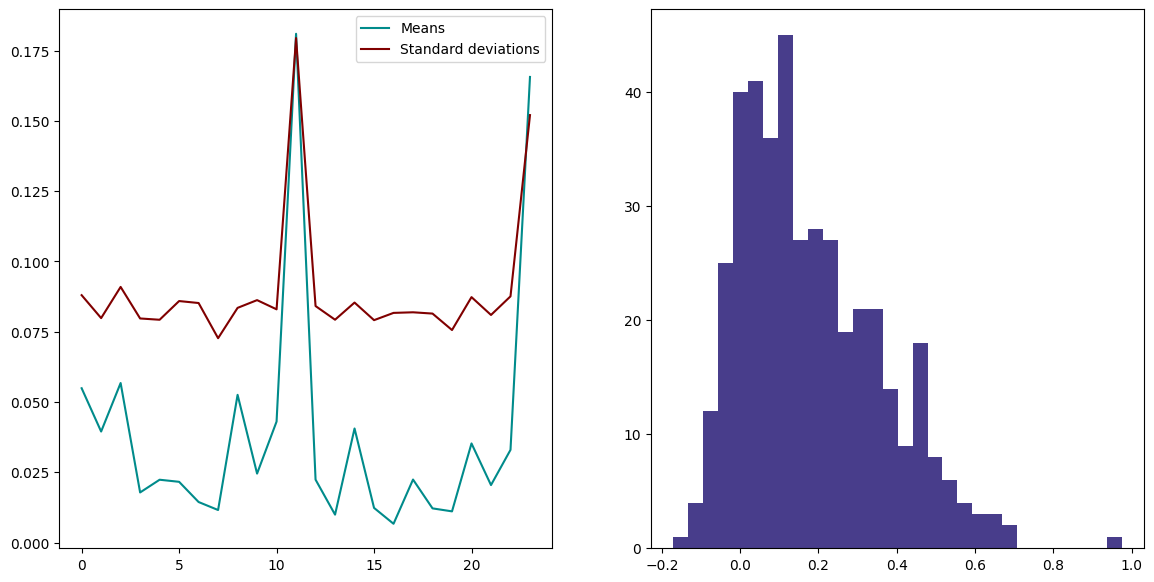

In [19]:
thetas_tot = torch.stack(thetas, dim=1)


fig, (fig1, fig2) = plt.subplots(1,2, figsize=(14,7))
fig1.plot(torch.mean(thetas_tot, dim=1).cpu(),  color="darkcyan", label="Means")
fig1.plot(torch.std(thetas_tot, dim=1).cpu(),  color="maroon", label = "Standard deviations")
fig1.legend()
fig2.hist((thetas_tot[11,:]).cpu(), bins=30, color="darkslateblue")


## Bottom-up (BU)

We check that the BU approach has the same MSE on the categories as the linear regression.

In [20]:
#validation
h_learn = 24
start =  12*18*3//5
end =  12*18*4//5
lambdas = {
    "lambda_tot": 0,
    "lambda_states": 0,
    "lambda_zones": 0,
    "lambda_regions": 0,
    "lambda_categories":1}

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_BU, se_by_level = weakl_bottom(lambdas, h_learn, start, end, tourism_data)

MSE total:  tensor(5925843.0861, device='cuda:0')
MSE states:  tensor(2436833.0614, device='cuda:0')
MSE zones:  tensor(1444344.8115, device='cuda:0')
MSE regions:  tensor(1149683.7038, device='cuda:0')
MSE categories:  tensor(1089953.4568, device='cuda:0')
MSE hier:  tensor(12046658.1198, device='cuda:0')


In [21]:
#test
h_learn = 24
start = 12*18*4//5
end = 12*18
lambdas = {
    "lambda_tot": 0,
    "lambda_states": 0,
    "lambda_zones": 0,
    "lambda_regions": 0,
    "lambda_categories":1}

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_BU, se_by_level = weakl_bottom(lambdas, h_learn, start, end, tourism_data)

MSE total:  tensor(5246149.9760, device='cuda:0')
MSE states:  tensor(2036320.0476, device='cuda:0')
MSE zones:  tensor(1367516.7105, device='cuda:0')
MSE regions:  tensor(1194302.0697, device='cuda:0')
MSE categories:  tensor(1173389.5580, device='cuda:0')
MSE hier:  tensor(11017678.3616, device='cuda:0')


In [22]:
n_test =se_by_level.shape[0]
print("MSE total: " +str(se_by_level["total"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["total"],12))))
print("MSE states: " +str(se_by_level["states"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["states"],12))))
print("MSE zones: " +str(se_by_level["zones"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["zones"],12))))
print("MSE regions: " +str(se_by_level["regions"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["regions"],12))))
print("MSE categories: " +str(se_by_level["categories"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["categories"],12))))
print("MSE hier: " +str(se_by_level["hier"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["hier"],12))))

MSE total: 5246149.975955855 -+ 520660.6565193377
MSE states: 2036320.0475754635 -+ 186509.42134938156
MSE zones: 1367516.710466954 -+ 49690.80748089177
MSE regions: 1194302.0696661074 -+ 24819.231674707113
MSE categories: 1173389.5579722286 -+ 31060.191963416226
MSE hier: 11017678.361636607 -+ 678352.5742465254


## WeaKL-BU

In [23]:
print(t_s*s_z*z_r*r_c)
print(s_z*z_r*r_c)
print(z_r*r_c)
print(r_c)

tensor(0.2244, device='cuda:0')
tensor(0.4573, device='cuda:0')
tensor(0.8515, device='cuda:0')
tensor(1.0138, device='cuda:0')


In [24]:
#Validation
h_learn = 24
start = 12*18*3//5
end = 12*18*4//5

lambdas = {
    "lambda_tot": 0.4,
    "lambda_states": 0.6,
    "lambda_zones": 0.9,
    "lambda_regions": 1,
    "lambda_categories":10}

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_WEAKL, se_by_level = weakl_bottom(lambdas, h_learn, start, end, tourism_data)

MSE total:  tensor(5609124.6335, device='cuda:0')
MSE states:  tensor(2361189.8184, device='cuda:0')
MSE zones:  tensor(1430857.2802, device='cuda:0')
MSE regions:  tensor(1148909.6574, device='cuda:0')
MSE categories:  tensor(1097106.1554, device='cuda:0')
MSE hier:  tensor(11647187.5449, device='cuda:0')


In [25]:
#Test
start = 12*18*4//5
end = 12*18

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_WEAKL, se_by_level =  weakl_bottom(lambdas, h_learn, start, end, tourism_data)

MSE total:  tensor(4452257.9507, device='cuda:0')
MSE states:  tensor(1912435.1968, device='cuda:0')
MSE zones:  tensor(1339523.7137, device='cuda:0')
MSE regions:  tensor(1187416.6810, device='cuda:0')
MSE categories:  tensor(1174179.1024, device='cuda:0')
MSE hier:  tensor(10065812.6446, device='cuda:0')


In [26]:
n_test =se_by_level.shape[0]
print("MSE total: " +str(se_by_level["total"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["total"],12))))
print("MSE states: " +str(se_by_level["states"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["states"],12))))
print("MSE zones: " +str(se_by_level["zones"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["zones"],12))))
print("MSE regions: " +str(se_by_level["regions"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["regions"],12))))
print("MSE categories: " +str(se_by_level["categories"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["categories"],12))))
print("MSE hier: " +str(se_by_level["hier"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["hier"],12))))

MSE total: 4452257.950698123 -+ 448187.9030921545
MSE states: 1912435.1968154474 -+ 187675.9186372014
MSE zones: 1339523.7136807651 -+ 53376.28609534896
MSE regions: 1187416.6809949197 -+ 25051.307463751255
MSE categories: 1174179.1023977315 -+ 30507.266904814995
MSE hier: 10065812.644586988 -+ 594482.7312874661


## OLS reconciliation (Rec_OLS)

In [27]:
h_learn = 24
start =  12*18*4//5
end =  12*18*5//5

thetas = linear_weights(h_learn, start, tourism_data)
mse_tot, mse_states, mse_zones, mse_regions, mse_categories, se_by_level = reconciliation_ols(h_learn, start, end, tourism_data, thetas)

MSE total:  tensor(3486764.0988, device='cuda:0')
MSE states:  tensor(1748905.4768, device='cuda:0')
MSE zones:  tensor(1347710.1743, device='cuda:0')
MSE regions:  tensor(1180297.0491, device='cuda:0')
MSE categories:  tensor(1169888.3028, device='cuda:0')
MSE hier:  tensor(8933565.1017, device='cuda:0')


In [28]:
n_test =se_by_level.shape[0]
print("MSE total: " +str(se_by_level["total"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["total"],12))))
print("MSE states: " +str(se_by_level["states"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["states"],12))))
print("MSE zones: " +str(se_by_level["zones"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["zones"],12))))
print("MSE regions: " +str(se_by_level["regions"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["regions"],12))))
print("MSE categories: " +str(se_by_level["categories"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["categories"],12))))
print("MSE hier: " +str(se_by_level["hier"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["hier"],12))))

MSE total: 3486764.098770368 -+ 522902.11929006164
MSE states: 1748905.4768160568 -+ 204279.2467614113
MSE zones: 1347710.1742538335 -+ 50135.812982031195
MSE regions: 1180297.0490814494 -+ 24028.396800468377
MSE categories: 1169888.3028260646 -+ 31994.00024323915
MSE hier: 8933565.101747774 -+ 699585.8007470933


## MinT

In [29]:
h_learn = 24
start =  12*18*4//5
end =  12*18*5

thetas = linear_weights(h_learn, start, tourism_data)
mse_tot, mse_states, mse_zones, mse_regions, mse_categories, se_by_level = reconciliation_mint(h_learn, start, end, tourism_data, thetas)

/tmp/tmp-d07784/ipykernel_62058/444485770.py:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  lambda_D = (ones.T@Corr_var@ones-torch.sum(torch.diagonal(Corr_var)))/(ones.T@torch.square(Corr_mat)@ones-torch.sum(torch.diagonal(torch.square(Corr_mat))))


Lambda_D =  tensor(0.7158, device='cuda:0')
MSE total:  tensor(3614305.9454, device='cuda:0')
MSE states:  tensor(1692258.7235, device='cuda:0')
MSE zones:  tensor(1290891.1613, device='cuda:0')
MSE regions:  tensor(1152022.0279, device='cuda:0')
MSE categories:  tensor(1168738.2998, device='cuda:0')
MSE hier:  tensor(8918216.1579, device='cuda:0')


In [30]:
n_test =se_by_level.shape[0]
print("MSE total: " +str(se_by_level["total"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["total"],12))))
print("MSE states: " +str(se_by_level["states"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["states"],12))))
print("MSE zones: " +str(se_by_level["zones"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["zones"],12))))
print("MSE regions: " +str(se_by_level["regions"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["regions"],12))))
print("MSE categories: " +str(se_by_level["categories"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["categories"],12))))
print("MSE hier: " +str(se_by_level["hier"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["hier"],12))))

MSE total: 3614305.9454226866 -+ 363829.6953740815
MSE states: 1692258.7234534677 -+ 149377.90769126322
MSE zones: 1290891.1612754313 -+ 48110.869637077594
MSE regions: 1152022.0279023894 -+ 29550.69766741703
MSE categories: 1168738.2998495821 -+ 27628.425848981118
MSE hier: 8918216.157903556 -+ 513568.8621769181


## WeaKL-G

In [31]:
h_learn = 24
start = 12*18*3//5
end = 12*18*4//5

lambdas = {
    "lambda_tot": 0,
    "lambda_states": 0,
    "lambda_zones": 0,
    "lambda_regions": 0,
    "lambda_categories":0}

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_WEAKL, se_by_level = weakl_global(lambdas, h_learn, start, end, tourism_data)

Training:  1 / 105
Training:  2 / 105
Training:  3 / 105
Training:  4 / 105
Training:  5 / 105
Training:  6 / 105
Training:  7 / 105
Training:  8 / 105
Training:  9 / 105
Training:  10 / 105
Training:  11 / 105
Training:  12 / 105
Training:  13 / 105
Training:  14 / 105
Training:  15 / 105
Training:  16 / 105
Training:  17 / 105
Training:  18 / 105
Training:  19 / 105
Training:  20 / 105
Training:  21 / 105
Training:  22 / 105
Training:  23 / 105
Training:  24 / 105
Training:  25 / 105
Training:  26 / 105
Training:  27 / 105
Training:  28 / 105
Training:  29 / 105
Training:  30 / 105
Training:  31 / 105
Training:  32 / 105
Training:  33 / 105
Training:  34 / 105
Training:  35 / 105
Training:  36 / 105
Training:  37 / 105
Training:  38 / 105
Training:  39 / 105
Training:  40 / 105
Training:  41 / 105
Training:  42 / 105
Training:  43 / 105
Training:  44 / 105
Training:  45 / 105
Training:  46 / 105
Training:  47 / 105
Training:  48 / 105
Training:  49 / 105
Training:  50 / 105
Training:

We check that setting $\Lambda = 0$ leads to the standard linear regression.


In [32]:
#Validation
h_learn = 24
start = 12*18*3//5
end = 12*18*4//5

lambdas = {
    "lambda_tot": 1,
    "lambda_states": 1,
    "lambda_zones": 1,
    "lambda_regions": 1,
    "lambda_categories":0}

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_WEAKL, se_by_level = weakl_global(lambdas, h_learn, start, end, tourism_data)

Training:  1 / 105
Training:  2 / 105
Training:  3 / 105
Training:  4 / 105
Training:  5 / 105
Training:  6 / 105
Training:  7 / 105
Training:  8 / 105
Training:  9 / 105
Training:  10 / 105
Training:  11 / 105
Training:  12 / 105
Training:  13 / 105
Training:  14 / 105
Training:  15 / 105
Training:  16 / 105
Training:  17 / 105
Training:  18 / 105
Training:  19 / 105
Training:  20 / 105
Training:  21 / 105
Training:  22 / 105
Training:  23 / 105
Training:  24 / 105
Training:  25 / 105
Training:  26 / 105
Training:  27 / 105
Training:  28 / 105
Training:  29 / 105
Training:  30 / 105
Training:  31 / 105
Training:  32 / 105
Training:  33 / 105
Training:  34 / 105
Training:  35 / 105
Training:  36 / 105
Training:  37 / 105
Training:  38 / 105
Training:  39 / 105
Training:  40 / 105
Training:  41 / 105
Training:  42 / 105
Training:  43 / 105
Training:  44 / 105
Training:  45 / 105
Training:  46 / 105
Training:  47 / 105
Training:  48 / 105
Training:  49 / 105
Training:  50 / 105
Training:

In [33]:
#Test
h_learn = 24
start = 12*18*4//5
end = 12*18

lambdas = {
    "lambda_tot": 1,
    "lambda_states": 1,
    "lambda_zones": 1,
    "lambda_regions": 1,
    "lambda_categories":0}

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_WEAKL, se_by_level = weakl_global(lambdas, h_learn, start, end, tourism_data)

Training:  1 / 148
Training:  2 / 148
Training:  3 / 148
Training:  4 / 148
Training:  5 / 148
Training:  6 / 148
Training:  7 / 148
Training:  8 / 148
Training:  9 / 148
Training:  10 / 148
Training:  11 / 148
Training:  12 / 148
Training:  13 / 148
Training:  14 / 148
Training:  15 / 148
Training:  16 / 148
Training:  17 / 148
Training:  18 / 148
Training:  19 / 148
Training:  20 / 148
Training:  21 / 148
Training:  22 / 148
Training:  23 / 148
Training:  24 / 148
Training:  25 / 148
Training:  26 / 148
Training:  27 / 148
Training:  28 / 148
Training:  29 / 148
Training:  30 / 148
Training:  31 / 148
Training:  32 / 148
Training:  33 / 148
Training:  34 / 148
Training:  35 / 148
Training:  36 / 148
Training:  37 / 148
Training:  38 / 148
Training:  39 / 148
Training:  40 / 148
Training:  41 / 148
Training:  42 / 148
Training:  43 / 148
Training:  44 / 148
Training:  45 / 148
Training:  46 / 148
Training:  47 / 148
Training:  48 / 148
Training:  49 / 148
Training:  50 / 148
Training:

In [34]:
n_test =se_by_level.shape[0]
print("MSE total: " +str(se_by_level["total"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["total"],12))))
print("MSE states: " +str(se_by_level["states"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["states"],12))))
print("MSE zones: " +str(se_by_level["zones"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["zones"],12))))
print("MSE regions: " +str(se_by_level["regions"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["regions"],12))))
print("MSE categories: " +str(se_by_level["categories"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["categories"],12))))
print("MSE hier: " +str(se_by_level["hier"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["hier"],12))))

MSE total: 3545230.035747455 -+ 533313.6142251722
MSE states: 1753370.06800035 -+ 172976.27155825795
MSE zones: 1367720.7358527044 -+ 50189.78308622349
MSE regions: 1188439.5560644032 -+ 25802.190265748737
MSE categories: 1146892.5025209654 -+ 31959.4197924162
MSE hier: 9001652.898185877 -+ 666244.6262153103


## WeaKL-T

Here, we run two hyperparameter tuning procedures. The second grid is based on the first one but has a finer scale. This aims at saving computational resources, while being able to test a finer grid.

### First hyperparameter tuning

In [35]:
import itertools

grid_cartesian = np.array([[0., 0.1, 1., 10.] for i in range(5)])
grid = list(itertools.product(*grid_cartesian))
l = len(grid)

In [36]:
h_list = [i for i in range(0, 24)] #h correspond au lag h_learn-h
h_learn=24

start = 12*18*3//5
end = 12*18*4//5

mse_hier_min = torch.inf

counter=0
for (l_r, l_t, l_s, l_z, l_r2) in grid:
  lambdas = {
      "lambda_tot": l_t,
      "lambda_states": l_s,
      "lambda_zones": l_z,
      "lambda_regions": l_r2,
      "lambda_categories":1}
  lambda_r = l_r

  mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_transfer, se_by_level = weakl_bu_transfer(lambdas, lambda_r, h_learn, h_list, start, end, tourism_data)
  if mse_hier_min > mse_hier:
    mse_hier_min = mse_hier
    best_lambdas = lambdas
    best_lr = l_r
  counter+=1
  print(counter/l*100, "% done.")

MSE total:  tensor(5.9258, device='cuda:0')
MSE states:  tensor(2.4368, device='cuda:0')
MSE zones:  tensor(1.4443, device='cuda:0')
MSE regions:  tensor(1.1497, device='cuda:0')
MSE categories:  tensor(1.0900, device='cuda:0')
MSE hier:  tensor(12.0467, device='cuda:0')
0.09765625 % done.
MSE total:  tensor(5.9028, device='cuda:0')
MSE states:  tensor(2.4312, device='cuda:0')
MSE zones:  tensor(1.4429, device='cuda:0')
MSE regions:  tensor(1.1490, device='cuda:0')
MSE categories:  tensor(1.0902, device='cuda:0')
MSE hier:  tensor(12.0160, device='cuda:0')
0.1953125 % done.
MSE total:  tensor(5.3183, device='cuda:0')
MSE states:  tensor(2.5008, device='cuda:0')
MSE zones:  tensor(1.6165, device='cuda:0')
MSE regions:  tensor(1.3782, device='cuda:0')
MSE categories:  tensor(1.3669, device='cuda:0')
MSE hier:  tensor(12.1807, device='cuda:0')
0.29296875 % done.
MSE total:  tensor(7.8907, device='cuda:0')
MSE states:  tensor(6.7270, device='cuda:0')
MSE zones:  tensor(6.1980, device='cuda

In [37]:
print(best_lambdas)
print(best_lr)

{'lambda_tot': 1.0, 'lambda_states': 0.1, 'lambda_zones': 0.1, 'lambda_regions': 0.1, 'lambda_categories': 1}
1.0


In [38]:
# best_lr =1.0
# best_lambdas = {'lambda_tot': 1.0, 'lambda_states': 0.1, 'lambda_zones': 0.1, 'lambda_regions': 0.1, 'lambda_categories': 1}

lambda_r = best_lr
lambdas = best_lambdas
start = 12*18*4//5
end = 12*18

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_transfer, se_by_level = weakl_bu_transfer(lambdas, lambda_r, h_learn, h_list, start, end, tourism_data)


MSE total:  tensor(2.6906, device='cuda:0')
MSE states:  tensor(1.7233, device='cuda:0')
MSE zones:  tensor(1.3975, device='cuda:0')
MSE regions:  tensor(1.2725, device='cuda:0')
MSE categories:  tensor(1.2481, device='cuda:0')
MSE hier:  tensor(8.3319, device='cuda:0')


### Second tuning

In [39]:
import itertools

grid_cartesian = np.array([[0.3, 1., 3.],
                           [0.3, 1., 3.],
                           [0.03, 0.1, 0.3],
                           [0.03, 0.1, 0.3],
                           [0.03, 0.1, 0.3]])
grid = list(itertools.product(*grid_cartesian))
l = len(grid)

h_list = [i for i in range(0, 24)] #h correspond au lag h_learn-h
h_learn=24

start = 12*18*3//5
end = 12*18*4//5

mse_hier_min = torch.inf

counter=0
for (l_r, l_t, l_s, l_z, l_r2) in grid:
  lambdas = {
      "lambda_tot": l_t,
      "lambda_states": l_s,
      "lambda_zones": l_z,
      "lambda_regions": l_r2,
      "lambda_categories":1}
  lambda_r = l_r

  mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_transfer, se_by_level = weakl_bu_transfer(lambdas, lambda_r, h_learn, h_list, start, end, tourism_data)
  if mse_hier_min > mse_hier:
    mse_hier_min = mse_hier
    best_lambdas = lambdas
    best_lr = l_r
  counter+=1
  print(counter/l*100, "% done.")

MSE total:  tensor(4.6163, device='cuda:0')
MSE states:  tensor(2.1095, device='cuda:0')
MSE zones:  tensor(1.2951, device='cuda:0')
MSE regions:  tensor(1.0545, device='cuda:0')
MSE categories:  tensor(1.0142, device='cuda:0')
MSE hier:  tensor(10.0895, device='cuda:0')
0.411522633744856 % done.
MSE total:  tensor(4.6174, device='cuda:0')
MSE states:  tensor(2.1091, device='cuda:0')
MSE zones:  tensor(1.2951, device='cuda:0')
MSE regions:  tensor(1.0544, device='cuda:0')
MSE categories:  tensor(1.0148, device='cuda:0')
MSE hier:  tensor(10.0909, device='cuda:0')
0.823045267489712 % done.
MSE total:  tensor(4.6268, device='cuda:0')
MSE states:  tensor(2.1084, device='cuda:0')
MSE zones:  tensor(1.2976, device='cuda:0')
MSE regions:  tensor(1.0556, device='cuda:0')
MSE categories:  tensor(1.0220, device='cuda:0')
MSE hier:  tensor(10.1104, device='cuda:0')
1.2345679012345678 % done.
MSE total:  tensor(4.6139, device='cuda:0')
MSE states:  tensor(2.1058, device='cuda:0')
MSE zones:  tens

In [40]:
print(best_lambdas)
print(best_lr)

{'lambda_tot': 0.3, 'lambda_states': 0.1, 'lambda_zones': 0.1, 'lambda_regions': 0.03, 'lambda_categories': 1}
1.0


In [41]:
# best_lr = 1.0
# best_lambdas = {'lambda_tot': 0.3, 'lambda_states': 0.1, 'lambda_zones': 0.1, 'lambda_regions': 0.03, 'lambda_categories': 1}
h_list = [i for i in range(0, 24)] #h correspond au lag h_learn-h
h_learn=24
lambda_r = best_lr
lambdas = best_lambdas
start = 12*18*4//5
end = 12*18

mse_tot, mse_states, mse_zones, mse_regions, mse_categories, mse_hier, theta_transfer, se_by_level = weakl_bu_transfer(lambdas, lambda_r, h_learn, h_list, start, end, tourism_data)


MSE total:  tensor(3.0623, device='cuda:0')
MSE states:  tensor(1.6595, device='cuda:0')
MSE zones:  tensor(1.2711, device='cuda:0')
MSE regions:  tensor(1.1521, device='cuda:0')
MSE categories:  tensor(1.1260, device='cuda:0')
MSE hier:  tensor(8.2709, device='cuda:0')


In [42]:
n_test =se_by_level.shape[0]
print("MSE total: " +str(se_by_level["total"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["total"],12))))
print("MSE states: " +str(se_by_level["states"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["states"],12))))
print("MSE zones: " +str(se_by_level["zones"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["zones"],12))))
print("MSE regions: " +str(se_by_level["regions"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["regions"],12))))
print("MSE categories: " +str(se_by_level["categories"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["categories"],12))))
print("MSE hier: " +str(se_by_level["hier"].mean())+ " -+ "+str(1/np.sqrt(n_test)*np.sqrt(mbb_var(se_by_level["hier"],12))))

MSE total: 3.0622547818617316 -+ 0.34294251969767103
MSE states: 1.659505637954397 -+ 0.1414846281535945
MSE zones: 1.2711022096127644 -+ 0.04591777088586882
MSE regions: 1.1520754467167762 -+ 0.023459135385410463
MSE categories: 1.1259771649789247 -+ 0.030154876587399407
MSE hier: 8.270915241124595 -+ 0.4307229141006
